In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()
from copy import deepcopy
import catboost as cgb
import imp
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import r2_score , mean_squared_error
import lightgbm
from scipy.interpolate import interp1d
url="C:/Users/louis/Downloads/Projet/"

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [3]:
def _haversine_distance(lat_A, lon_A, lat_B, lon_B):
    earth_radius = 6373
    distance = np.sin((lat_B - lat_A) / 2) ** 2 + np.cos(lat_A) * \
               np.cos(lat_B) * np.sin((lon_B - lon_A) / 2) ** 2
    distance = 2 * earth_radius * np.arcsin(distance)
    return distance



problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_encoded = X_df

url="C:/Users/louis/Downloads/Projet/"
final = pd.read_csv(url+"Ajout_données.csv")
final["Date"]=pd.to_datetime(final["Date"])

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date -pd.to_datetime("1970-01-01")).days)
X_df_Depart = X_encoded.drop("Arrival", axis=1)
X_df_Arrivee = X_encoded.drop("Departure", axis=1)


fusion_depart = X_df_Depart.merge(final.add_suffix('_depart'),how="left", \
left_on=["DateOfDeparture","Departure"],right_on=["Date_depart","AirPort_depart"])
fusion_arrivee = X_df_Arrivee.merge(final.add_suffix('_arrivee'),how="left",\
left_on=["DateOfDeparture","Arrival"],right_on=["Date_arrivee","AirPort_arrivee"])
fusion_arrivee=fusion_arrivee.drop(["DateOfDeparture","WeeksToDeparture",\
                                                          "std_wtd","year","month","day","weekday","week","n_days"],axis=1)
perfect = fusion_depart.merge(fusion_arrivee, left_index=True, right_index=True)

perfect["Precipitationmm_arrivee"]=np.where(perfect["Precipitationmm_arrivee"] == 'T',0,perfect["Precipitationmm_arrivee"])
perfect["Events_arrivee"]=perfect["Events_arrivee"].fillna("Sunny")
perfect["Precipitationmm_depart"]=np.where(perfect["Precipitationmm_depart"] == 'T',0,perfect["Precipitationmm_depart"])
perfect["Events_depart"]=perfect["Events_depart"].fillna("Sunny")
perfect = perfect.join(pd.get_dummies(perfect['Events_depart'], prefix='d'))
perfect = perfect.join(pd.get_dummies(perfect['Events_arrivee'], prefix='a'))
perfect = perfect.drop('Events_depart', axis=1)
perfect = perfect.drop('Events_arrivee', axis=1)
liste_flo = ["lat_arrivee","lon_arrivee","Precipitationmm_arrivee","lat_depart","lon_depart","Precipitationmm_depart"]
perfect[liste_flo]=perfect[liste_flo].astype(float)
perfect['distance'] = _haversine_distance(\
              perfect['lat_arrivee'].values,\
              perfect['lon_arrivee'].values,\
              perfect['lat_depart'].values,\
              perfect['lon_depart'].values)
del perfect["DateOfDeparture"]
perfect=perfect.drop(["DateOfDeparture_arrivee","Date_depart",\
          "DateOfDeparture_depart","Date_arrivee","City_arrivee",\
          "State_arrivee","City_depart","State_depart","AirPort_arrivee",\
          "AirPort_depart","is_weekend_depart","is_holiday_depart",\
          "is_close_from_weekend_or_holiday_depart"],axis=1)
perfect = perfect.rename(columns={'is_weekend_arrivee': 'is_weekend',\
          'is_holiday_arrivee':'is_holiday',\
          'is_close_from_weekend_or_holiday_arrivee':'is_close_from_weekend_or_holiday'})
#perfect=perfect.drop([c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.object],axis=1)
perfect = perfect.join(pd.get_dummies(perfect['Departure'], prefix='d'))
perfect = perfect.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
perfect = perfect.drop('Departure', axis=1)
perfect = perfect.drop('Arrival', axis=1)
del perfect["a_Sunny"]
for i in [c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.bool] :
            perfect[i]=np.where(perfect[i] == False,0,1)   

hide_toggle()

### CatBoost non tuné

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

In [5]:
cat_boost = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.01,
    depth = 5,
    rsm =0.9,
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9802430	test: 1.0165762	best: 1.0165762 (0)	total: 78.4ms	remaining: 13m 4s
50:	learn: 0.8629105	test: 0.9058037	best: 0.9058037 (50)	total: 655ms	remaining: 2m 7s
100:	learn: 0.7962904	test: 0.8431213	best: 0.8431213 (100)	total: 1.17s	remaining: 1m 54s
150:	learn: 0.7528772	test: 0.8013117	best: 0.8013117 (150)	total: 1.73s	remaining: 1m 53s
200:	learn: 0.7189341	test: 0.7677570	best: 0.7677570 (200)	total: 2.3s	remaining: 1m 51s
250:	learn: 0.6916885	test: 0.7401224	best: 0.7401224 (250)	total: 2.82s	remaining: 1m 49s
300:	learn: 0.6689997	test: 0.7174823	best: 0.7174823 (300)	total: 3.33s	remaining: 1m 47s
350:	learn: 0.6496522	test: 0.6979766	best: 0.6979766 (350)	total: 3.85s	remaining: 1m 45s
400:	learn: 0.6334029	test: 0.6813524	best: 0.6813524 (400)	total: 4.39s	remaining: 1m 44s
450:	learn: 0.6175264	test: 0.6653999	best: 0.6653999 (450)	total: 4.89s	remaining: 1m 43s
500:	learn: 0.6034518	test: 0.6515407	best: 0.6515407 (500)	total: 5.42s	remaining: 1m 42s
550:	l

4450:	learn: 0.3058357	test: 0.4240021	best: 0.4240021 (4450)	total: 53.6s	remaining: 1m 6s
4500:	learn: 0.3043623	test: 0.4234540	best: 0.4234445 (4496)	total: 54.5s	remaining: 1m 6s
4550:	learn: 0.3029865	test: 0.4229995	best: 0.4229995 (4550)	total: 55.4s	remaining: 1m 6s
4600:	learn: 0.3016218	test: 0.4224639	best: 0.4224622 (4599)	total: 55.9s	remaining: 1m 5s
4650:	learn: 0.3003911	test: 0.4221764	best: 0.4221764 (4650)	total: 56.7s	remaining: 1m 5s
4700:	learn: 0.2990223	test: 0.4216451	best: 0.4216451 (4700)	total: 57.2s	remaining: 1m 4s
4750:	learn: 0.2977245	test: 0.4211180	best: 0.4211180 (4750)	total: 57.9s	remaining: 1m 4s
4800:	learn: 0.2963417	test: 0.4205644	best: 0.4205644 (4800)	total: 58.5s	remaining: 1m 3s
4850:	learn: 0.2950264	test: 0.4199610	best: 0.4199610 (4850)	total: 59.3s	remaining: 1m 2s
4900:	learn: 0.2937431	test: 0.4194919	best: 0.4194919 (4900)	total: 59.8s	remaining: 1m 2s
4950:	learn: 0.2925661	test: 0.4191633	best: 0.4191622 (4949)	total: 1m	remainin

In [6]:
pd.set_option('display.max_rows',200)
imp= cat_boost.get_feature_importance()
importance_features = pd.DataFrame({"coeff":imp,"variables":X.columns})
importance_features.sort_values("coeff",ascending=False)

coeff                                         variables
5    15.444837                                           weekday
60    9.576636                                        is_weekend
67    7.433092  Net_domestic_migration_rate_per_1000_hab_arrivee
33    7.185511   Net_domestic_migration_rate_per_1000_hab_depart
103   6.329757                                          distance
6     6.295614                                              week
0     4.607208                                  WeeksToDeparture
7     3.437729                                            n_days
72    2.819495                           city_population_arrivee
38    2.571080                            city_population_depart
4     2.161950                                               day
110   2.123500                                             d_EWR
130   1.924399                                             a_EWR
70    1.860392                                       lon_arrivee
36    1.777201                                        lon_depart
61    1.324051                                        is_holiday
37    1.208080                                  elevation_depart
115   1.001507                                             d_LGA
71    0.964965                                 elevation_arrivee
66    0.945942                              Average Wage_arrivee
69    0.938003                                       lat_arrivee
35    0.917135                                        lat_depart
32    0.858410                               Average Wage_depart
1     0.746678                                           std_wtd
65    0.663686                             Median_income_arrivee
3     0.622825                                             month
30    0.584462                         Peer_capita_income_depart
10    0.584034                           Min TemperatureC_depart
9     0.577453                          Mean TemperatureC_depart
135   0.547982                                             a_LGA
63    0.546310                         Unemployment_Rate_arrivee
29    0.500293                          Unemployment_Rate_depart
64    0.499873                        Peer_capita_income_arrivee
109   0.487841                                             d_DTW
31    0.477886                              Median_income_depart
41    0.376560                          Min TemperatureC_arrivee
8     0.358509                           Max TemperatureC_depart
129   0.355461                                             a_DTW
62    0.343544                  is_close_from_weekend_or_holiday
119   0.327076                                             d_ORD
28    0.319087                             WindDirDegrees_depart
59    0.314902                            WindDirDegrees_arrivee
132   0.303471                                             a_JFK
131   0.287632                                             a_IAH
68    0.247101                                  TFR 2018_arrivee
39    0.234784                          Max TemperatureC_arrivee
45    0.233555                              Max Humidity_arrivee
56    0.226792                        Max Gust SpeedKm/h_arrivee
40    0.214264                         Mean TemperatureC_arrivee
139   0.208191                                             a_ORD
34    0.206407                                   TFR 2018_depart
48    0.197731                 Max Sea Level PressurehPa_arrivee
44    0.193020                             Min DewpointC_arrivee
111   0.190012                                             d_IAH
12    0.183600                             MeanDew PointC_depart
42    0.182985                                Dew PointC_arrivee
24    0.182606                        Mean Wind SpeedKm/h_depart
11    0.179102                                 Dew PointC_depart
47    0.167934                              Min Humidity_arrivee
55    0.166164                       Mean Wind SpeedKm/h_arrivee
15    0.165972                              

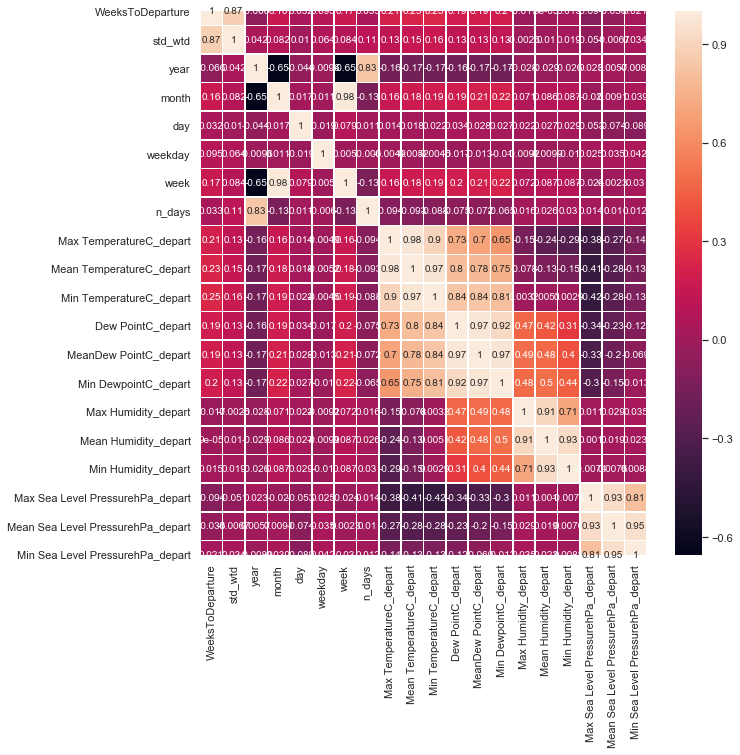

In [7]:
nom=list(importance_features.iloc[0:20,1])
import matplotlib.pyplot as plt

corr = perfect[nom].corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, annot=True,xticklabels=corr.columns,
        yticklabels=corr.columns, linewidths=.5, ax=ax)

In [8]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
print("Best RMSE avec paramètres fixés aléatoirement :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres fixés aléatoirement :0.3834375044068958


### Optimisation Bayésienne du CatBoost

In [10]:
from sklearn.model_selection import train_test_split
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.5, random_state=0)

In [12]:
def cat_hyp(depth, bagging_temperature,border_count,rsm, subsample,l2_leaf_reg): # Function to optimize depth and bagging temperature
    params = {"iterations": 95,
            "learning_rate": 0.2,
            "eval_metric": "RMSE",
            "verbose": False} # Default Parameters
    params["depth"] = int(round(depth)) 
    params["bagging_temperature"] = bagging_temperature
    params["l2_leaf_reg"]=l2_leaf_reg
    params["rsm"] = rsm
    #params["one_hot_max_size"]= int(round(one_hot_max_size))
    params["subsample"] = subsample
    #params['reg_lambda'] = reg_lambda
    params["border_count"]=int(round(border_count))
  
    cv_dataset = cgb.Pool(data=X,
                  label=y)

    scores = cgb.cv(cv_dataset,
              params,
              fold_count=8)
    return (-1.0 * np.array(scores['test-RMSE-mean'])).max() # Return maximum R-Squared value  

In [13]:
# Search space
pds = {'depth': (4, 15),
          'bagging_temperature': (0,15),
          'l2_leaf_reg': (1,100),
          'rsm' : (0.7,1),
          'border_count' : (1,255),
          #'one_hot_max_size':(1,40),
          'subsample': (0.2,1)
          #'reg_lambda' : (1.0, 100)
          }

# Surrogate model
optimizer = BayesianOptimization(cat_hyp, pds, random_state=2100)
                                  
# Optimize
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | baggin... | border... |   depth   | l2_lea... |    rsm    | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.5593   |  12.71    |  6.88     |  4.955    |  34.25    |  0.8467   |  0.44     |
|  2        | -0.6313   |  14.47    |  58.19    |  5.124    |  87.37    |  0.703    |  0.2144   |
|  3        | -0.6002   |  1.55     |  128.2    |  5.628    |  58.47    |  0.9405   |  0.6366   |
|  4        | -0.6898   |  6.957    |  241.6    |  13.51    |  71.79    |  0.938    |  0.2728   |
|  5        | -0.6408   |  10.23    |  41.52    |  10.71    |  56.58    |  0.7625   |  0.7831   |
|  6        | -0.5805   |  1.977    |  185.6    |  4.976    |  64.71    |  0.756    |  0.3887   |
|  7        | -0.6058   |  12.65    |  162.2    |  5.697    |  46.59    |  0.9833   |  0.3618   |
|  8        | -0.6592   |  1.354    |  153.7    |  11.54    |  66.15    |  0.7033   |  0.4899   |
|  9        | -0.544

In [14]:
best_param = optimizer.max
optimizer.max

{'target': -0.5239377024848976,
 'params': {'bagging_temperature': 0.0,
  'border_count': 220.00271880773116,
  'depth': 4.0,
  'l2_leaf_reg': 1.0,
  'rsm': 0.7,
  'subsample': 0.2}}

#### CatBoost tuné

In [54]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

cat_boost = CatBoostRegressor(
    iterations=25000,
    learning_rate=0.01,
    l2_leaf_reg= best_param["params"]["l2_leaf_reg"],
    depth = int(round(best_param["params"]["depth"],0)),
    bagging_temperature = best_param["params"]["bagging_temperature"],
    border_count = int(round(best_param["params"]["border_count"],0)),
    #one_hot_max_size=20.3249397,
    rsm =best_param["params"]["rsm"],
    #subsample = best_param["params"]["subsample"],
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9803866	test: 1.0167034	best: 1.0167034 (0)	total: 3.63ms	remaining: 1m 30s
50:	learn: 0.8747374	test: 0.9176729	best: 0.9176729 (50)	total: 194ms	remaining: 1m 34s
100:	learn: 0.8149177	test: 0.8618887	best: 0.8618887 (100)	total: 392ms	remaining: 1m 36s
150:	learn: 0.7765892	test: 0.8248872	best: 0.8248872 (150)	total: 677ms	remaining: 1m 51s
200:	learn: 0.7475337	test: 0.7956284	best: 0.7956284 (200)	total: 846ms	remaining: 1m 44s
250:	learn: 0.7217218	test: 0.7689621	best: 0.7689621 (250)	total: 1.1s	remaining: 1m 48s
300:	learn: 0.7014462	test: 0.7487505	best: 0.7487505 (300)	total: 1.27s	remaining: 1m 44s
350:	learn: 0.6832704	test: 0.7301846	best: 0.7301846 (350)	total: 1.45s	remaining: 1m 42s
400:	learn: 0.6676208	test: 0.7140485	best: 0.7140485 (400)	total: 1.64s	remaining: 1m 40s
450:	learn: 0.6544084	test: 0.7010765	best: 0.7010765 (450)	total: 1.83s	remaining: 1m 39s
500:	learn: 0.6406756	test: 0.6869686	best: 0.6869686 (500)	total: 2.06s	remaining: 1m 40s
550:	

4500:	learn: 0.3486680	test: 0.4461755	best: 0.4461755 (4500)	total: 20.3s	remaining: 1m 32s
4550:	learn: 0.3473364	test: 0.4454828	best: 0.4454530 (4547)	total: 20.5s	remaining: 1m 31s
4600:	learn: 0.3461205	test: 0.4448460	best: 0.4448460 (4600)	total: 20.6s	remaining: 1m 31s
4650:	learn: 0.3448566	test: 0.4441996	best: 0.4441996 (4650)	total: 20.8s	remaining: 1m 31s
4700:	learn: 0.3435028	test: 0.4435529	best: 0.4435529 (4700)	total: 21s	remaining: 1m 30s
4750:	learn: 0.3420822	test: 0.4429384	best: 0.4429384 (4750)	total: 21.1s	remaining: 1m 30s
4800:	learn: 0.3408041	test: 0.4424309	best: 0.4424309 (4800)	total: 21.5s	remaining: 1m 30s
4850:	learn: 0.3396000	test: 0.4419337	best: 0.4419337 (4850)	total: 21.6s	remaining: 1m 29s
4900:	learn: 0.3383652	test: 0.4415377	best: 0.4415298 (4891)	total: 21.8s	remaining: 1m 29s
4950:	learn: 0.3371258	test: 0.4410913	best: 0.4410913 (4950)	total: 22s	remaining: 1m 28s
5000:	learn: 0.3358845	test: 0.4406458	best: 0.4406458 (5000)	total: 22.1s

9000:	learn: 0.2658971	test: 0.4186543	best: 0.4186543 (9000)	total: 40.1s	remaining: 1m 11s
9050:	learn: 0.2652247	test: 0.4184688	best: 0.4184688 (9050)	total: 40.3s	remaining: 1m 10s
9100:	learn: 0.2645673	test: 0.4182297	best: 0.4182297 (9100)	total: 40.4s	remaining: 1m 10s
9150:	learn: 0.2638821	test: 0.4180295	best: 0.4180295 (9150)	total: 41s	remaining: 1m 10s
9200:	learn: 0.2632039	test: 0.4178769	best: 0.4178703 (9191)	total: 41.2s	remaining: 1m 10s
9250:	learn: 0.2625802	test: 0.4176625	best: 0.4176625 (9250)	total: 41.3s	remaining: 1m 10s
9300:	learn: 0.2619704	test: 0.4175206	best: 0.4175105 (9299)	total: 41.5s	remaining: 1m 10s
9350:	learn: 0.2613933	test: 0.4173991	best: 0.4173988 (9335)	total: 41.7s	remaining: 1m 9s
9400:	learn: 0.2607107	test: 0.4171972	best: 0.4171972 (9400)	total: 42.2s	remaining: 1m 9s
9450:	learn: 0.2600850	test: 0.4169789	best: 0.4169776 (9448)	total: 42.4s	remaining: 1m 9s
9500:	learn: 0.2593972	test: 0.4168069	best: 0.4168048 (9499)	total: 42.6s	

In [55]:
pd.set_option('display.max_rows',200)
imp= cat_boost.get_feature_importance()
importance_features = pd.DataFrame({"coeff":imp,"variables":X.columns})
importance_features.sort_values("coeff",ascending=False)

coeff                                         variables
5    15.210357                                           weekday
60    9.501215                                        is_weekend
67    7.514005  Net_domestic_migration_rate_per_1000_hab_arrivee
33    6.702805   Net_domestic_migration_rate_per_1000_hab_depart
6     6.350114                                              week
103   6.126761                                          distance
0     4.794669                                  WeeksToDeparture
7     3.888123                                            n_days
72    2.521281                           city_population_arrivee
38    2.331615                            city_population_depart
110   2.089323                                             d_EWR
4     2.040163                                               day
130   1.953074                                             a_EWR
36    1.450396                                        lon_depart
70    1.431747                                       lon_arrivee
61    1.418986                                        is_holiday
115   1.064711                                             d_LGA
37    0.948297                                  elevation_depart
35    0.926387                                        lat_depart
1     0.879979                                           std_wtd
71    0.859037                                 elevation_arrivee
66    0.815059                              Average Wage_arrivee
30    0.714613                         Peer_capita_income_depart
32    0.700167                               Average Wage_depart
10    0.662358                           Min TemperatureC_depart
69    0.657571                                       lat_arrivee
3     0.629947                                             month
135   0.616016                                             a_LGA
109   0.586940                                             d_DTW
132   0.555811                                             a_JFK
65    0.550020                             Median_income_arrivee
9     0.547316                          Mean TemperatureC_depart
64    0.468621                        Peer_capita_income_arrivee
129   0.458209                                             a_DTW
8     0.435896                           Max TemperatureC_depart
112   0.429386                                             d_JFK
41    0.425436                          Min TemperatureC_arrivee
31    0.419215                              Median_income_depart
29    0.406912                          Unemployment_Rate_depart
131   0.393452                                             a_IAH
28    0.387898                             WindDirDegrees_depart
59    0.364380                            WindDirDegrees_arrivee
56    0.336810                        Max Gust SpeedKm/h_arrivee
34    0.334890                                   TFR 2018_depart
63    0.331929                         Unemployment_Rate_arrivee
40    0.303396                         Mean TemperatureC_arrivee
119   0.300531                                             d_ORD
139   0.284980                                             a_ORD
11    0.278388                                 Dew PointC_depart
62    0.260429                  is_close_from_weekend_or_holiday
45    0.260147                              Max Humidity_arrivee
12    0.256567                             MeanDew PointC_depart
111   0.253416                                             d_IAH
24    0.251185                        Mean Wind SpeedKm/h_depart
44    0.237482                             Min DewpointC_arrivee
48    0.228537                 Max Sea Level PressurehPa_arrivee
39    0.221195                          Max TemperatureC_arrivee
134   0.218842                                             a_LAX
68    0.218566                                  TFR 2018_arrivee
14    0.189760                               Max Humidity_depart
47    0.183655                              

In [56]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
print("Best RMSE avec paramètres optimisés :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres optimisés :0.3970968281831573


#### Limitation du bruit

In [58]:
to_keep=list(importance_features[importance_features["coeff"]>0.15]["variables"])
to_keep.append("log_PAX")

In [59]:
from sklearn.model_selection import train_test_split
import numpy as np
perfect["log_PAX"] = y_array
y = perfect["log_PAX"]
X = perfect.drop(["log_PAX"], axis=1)
cat_algo =[c for c, d in zip (X.columns,X.dtypes) if d==np.object]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

train_pool = Pool(data =X_train, label = y_train, cat_features=X[cat_algo])

validation_pool = Pool(data =X_val, label = y_val, cat_features=X[cat_algo])

test_pool = Pool(data =X_test, label = y_test, cat_features=X[cat_algo])

cat_boost = CatBoostRegressor(
    iterations=25000,
    learning_rate=0.01,
    l2_leaf_reg= best_param["params"]["l2_leaf_reg"],
    depth = int(round(best_param["params"]["depth"],0)),
    bagging_temperature = best_param["params"]["bagging_temperature"],
    border_count = int(round(best_param["params"]["border_count"],0)),
    #one_hot_max_size=20.3249397,
    rsm =best_param["params"]["rsm"],
    #subsample = best_param["params"]["subsample"],
    custom_metric ='RMSE',
    od_type='Iter',
    od_wait=20,
    eval_metric='RMSE'
    )

cat_boost.fit(train_pool,
              eval_set=validation_pool,
              verbose=50,
              plot=True
             )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9803866	test: 1.0167034	best: 1.0167034 (0)	total: 4.01ms	remaining: 1m 40s
50:	learn: 0.8747374	test: 0.9176729	best: 0.9176729 (50)	total: 197ms	remaining: 1m 36s
100:	learn: 0.8149177	test: 0.8618887	best: 0.8618887 (100)	total: 401ms	remaining: 1m 38s
150:	learn: 0.7765892	test: 0.8248872	best: 0.8248872 (150)	total: 667ms	remaining: 1m 49s
200:	learn: 0.7475337	test: 0.7956284	best: 0.7956284 (200)	total: 829ms	remaining: 1m 42s
250:	learn: 0.7217218	test: 0.7689621	best: 0.7689621 (250)	total: 1.06s	remaining: 1m 44s
300:	learn: 0.7014462	test: 0.7487505	best: 0.7487505 (300)	total: 1.24s	remaining: 1m 42s
350:	learn: 0.6832704	test: 0.7301846	best: 0.7301846 (350)	total: 1.43s	remaining: 1m 40s
400:	learn: 0.6676208	test: 0.7140485	best: 0.7140485 (400)	total: 1.66s	remaining: 1m 42s
450:	learn: 0.6544084	test: 0.7010765	best: 0.7010765 (450)	total: 1.83s	remaining: 1m 39s
500:	learn: 0.6406756	test: 0.6869686	best: 0.6869686 (500)	total: 2.05s	remaining: 1m 40s
550:

4450:	learn: 0.3498733	test: 0.4466348	best: 0.4466348 (4450)	total: 22.2s	remaining: 1m 42s
4500:	learn: 0.3486680	test: 0.4461755	best: 0.4461755 (4500)	total: 22.6s	remaining: 1m 42s
4550:	learn: 0.3473364	test: 0.4454828	best: 0.4454530 (4547)	total: 22.7s	remaining: 1m 42s
4600:	learn: 0.3461205	test: 0.4448460	best: 0.4448460 (4600)	total: 22.9s	remaining: 1m 41s
4650:	learn: 0.3448566	test: 0.4441996	best: 0.4441996 (4650)	total: 23.1s	remaining: 1m 40s
4700:	learn: 0.3435028	test: 0.4435529	best: 0.4435529 (4700)	total: 23.2s	remaining: 1m 40s
4750:	learn: 0.3420822	test: 0.4429384	best: 0.4429384 (4750)	total: 23.4s	remaining: 1m 39s
4800:	learn: 0.3408041	test: 0.4424309	best: 0.4424309 (4800)	total: 23.7s	remaining: 1m 39s
4850:	learn: 0.3396000	test: 0.4419337	best: 0.4419337 (4850)	total: 23.9s	remaining: 1m 39s
4900:	learn: 0.3383652	test: 0.4415377	best: 0.4415298 (4891)	total: 24.1s	remaining: 1m 38s
4950:	learn: 0.3371258	test: 0.4410913	best: 0.4410913 (4950)	total: 2

8950:	learn: 0.2665936	test: 0.4188821	best: 0.4188787 (8949)	total: 42.3s	remaining: 1m 15s
9000:	learn: 0.2658971	test: 0.4186543	best: 0.4186543 (9000)	total: 42.4s	remaining: 1m 15s
9050:	learn: 0.2652247	test: 0.4184688	best: 0.4184688 (9050)	total: 42.6s	remaining: 1m 15s
9100:	learn: 0.2645673	test: 0.4182297	best: 0.4182297 (9100)	total: 42.8s	remaining: 1m 14s
9150:	learn: 0.2638821	test: 0.4180295	best: 0.4180295 (9150)	total: 43.3s	remaining: 1m 14s
9200:	learn: 0.2632039	test: 0.4178769	best: 0.4178703 (9191)	total: 43.5s	remaining: 1m 14s
9250:	learn: 0.2625802	test: 0.4176625	best: 0.4176625 (9250)	total: 43.7s	remaining: 1m 14s
9300:	learn: 0.2619704	test: 0.4175206	best: 0.4175105 (9299)	total: 43.9s	remaining: 1m 14s
9350:	learn: 0.2613933	test: 0.4173991	best: 0.4173988 (9335)	total: 44.4s	remaining: 1m 14s
9400:	learn: 0.2607107	test: 0.4171972	best: 0.4171972 (9400)	total: 44.8s	remaining: 1m 14s
9450:	learn: 0.2600850	test: 0.4169789	best: 0.4169776 (9448)	total: 4

In [60]:
metrics = cat_boost.eval_metrics(test_pool,
                                'RMSE',
                                ntree_start=0,
                                ntree_end=0,
                                eval_period=1,
                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
print("Best RMSE avec paramètres optimisés :{}".format(min(metrics["RMSE"])))#0.3642373118047967

Best RMSE avec paramètres optimisés :0.3970968281831573


On voit ici que l'optimisation n'est, ici, pas d'un grand intérêt. En effet , d'une part le faible volume de donnés à disposition ne permet pas de rendre l'optimisation des paramètres réellement efficaces